In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ============================================
# LOAD DATA
# ============================================

print("="*60)
print("SVB COLLAPSE PREDICTION - TIMELINE ANALYSIS")
print("="*60)

# Load emotion data
posts = pd.read_csv('/Users/carolinerennier/Downloads/svb_posts_with_emotions_4weeks.csv')
comments = pd.read_csv('/Users/carolinerennier/Downloads/svb_comments_with_emotions_4weeks.csv')

# Load stock data
stock = pd.read_csv('svb_stock_jan2021_mar2023.csv')

print(f"\n✓ Loaded {len(posts)} posts")
print(f"✓ Loaded {len(comments)} comments")
print(f"✓ Loaded {len(stock)} stock bars")

# Combine emotions
all_emotions = pd.concat([posts, comments], ignore_index=True)
all_emotions['timestamp'] = pd.to_datetime(all_emotions['timestamp'])
stock['timestamp'] = pd.to_datetime(stock['timestamp'])

print(f"\n✓ Total emotion texts: {len(all_emotions)}")
print(f"  Date range: {all_emotions['timestamp'].min()} to {all_emotions['timestamp'].max()}")

# ============================================
# CREATE EMOTION INDICES
# ============================================

print("\nCreating emotion indices...")

all_emotions['FEAR_INDEX'] = (
    all_emotions['fear'] + 
    all_emotions['nervousness'] + 
    all_emotions['sadness']
) / 3

all_emotions['PANIC_INDEX'] = (
    all_emotions['fear'] + 
    all_emotions['nervousness']
) / 2

all_emotions['CAPITULATION_INDEX'] = (
    all_emotions['grief'] + 
    all_emotions['disappointment'] + 
    all_emotions['remorse']
) / 3

print("✓ Created emotion indices")

# ============================================
# AGGREGATE TO 6-HOUR WINDOWS
# ============================================

print("\nAggregating emotions to 6-hour windows...")

all_emotions['window'] = all_emotions['timestamp'].dt.floor('6h')
emotion_6h = all_emotions.groupby('window').agg({
    'FEAR_INDEX': 'mean',
    'PANIC_INDEX': 'mean',
    'CAPITULATION_INDEX': 'mean'
}).reset_index()

# Also count posts per window (for R0)
posts_per_window = all_emotions.groupby('window').size().reset_index(name='post_count')
emotion_6h = pd.merge(emotion_6h, posts_per_window, on='window')

print(f"✓ Aggregated to {len(emotion_6h)} 6-hour windows")

# ============================================
# PREPARE STOCK DATA (DAILY)
# ============================================

print("\nPreparing daily stock data...")

stock['date'] = stock['timestamp'].dt.date
stock_daily = stock.groupby('date').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).reset_index()

stock_daily['date'] = pd.to_datetime(stock_daily['date'])
stock_daily['returns'] = stock_daily['Close'].pct_change() * 100

print(f"✓ Prepared {len(stock_daily)} trading days")

# ============================================
# ANALYSIS 1: BASELINE vs CRISIS EMOTIONS (MARCH ONLY)
# ============================================

print("\n" + "="*60)
print("ANALYSIS 1: BASELINE VS CRISIS EMOTIONS")
print("="*60)

# FOCUS ON MARCH ONLY - Use March 1-7 as baseline
march_data = emotion_6h[emotion_6h['window'] >= '2023-03-01'].copy()

baseline_mask = (march_data['window'] >= '2023-03-01') & (march_data['window'] < '2023-03-08')
crisis_mask = march_data['window'] >= '2023-03-08'

baseline_fear = march_data[baseline_mask]['FEAR_INDEX'].mean()
baseline_std = march_data[baseline_mask]['FEAR_INDEX'].std()

crisis_fear = march_data[crisis_mask]['FEAR_INDEX'].mean()

print(f"\nBaseline Period (March 1-7):")
print(f"  Average Fear: {baseline_fear:.4f}")
print(f"  Std Dev: {baseline_std:.4f}")

print(f"\nCrisis Period (March 8-10):")
print(f"  Average Fear: {crisis_fear:.4f}")
print(f"  Increase: {((crisis_fear - baseline_fear) / baseline_fear * 100):.1f}%")

# ============================================
# ANALYSIS 2: EARLY WARNING DETECTION (MARCH ONLY)
# ============================================

print("\n" + "="*60)
print("ANALYSIS 2: EARLY WARNING DETECTION")
print("="*60)

# Define spike threshold (2.5 standard deviations for tighter detection)
spike_threshold = baseline_fear + 2.5 * baseline_std

march_data['is_spike'] = march_data['FEAR_INDEX'] > spike_threshold

# Find first spike in MARCH
spikes = march_data[march_data['is_spike'] & (march_data['window'] >= '2023-03-08')]

if len(spikes) > 0:
    first_spike = spikes.iloc[0]
    
    print(f"\nSpike Threshold (2.5σ above March baseline): {spike_threshold:.4f}")
    print(f"\nFIRST FEAR SPIKE DETECTED:")
    print(f"  Time: {first_spike['window']}")
    print(f"  Fear Level: {first_spike['FEAR_INDEX']:.4f}")
    print(f"  Above baseline: {((first_spike['FEAR_INDEX'] - baseline_fear) / baseline_fear * 100):.1f}%")
    
    # Calculate warning time
    # Stock crash = March 9, 9:30 AM opening
    crash_time = pd.Timestamp('2023-03-09 09:30:00')
    warning_hours = (crash_time - first_spike['window']).total_seconds() / 3600
    
    print(f"\n⚠️ EARLY WARNING:")
    print(f"  Spike detected: {first_spike['window']}")
    print(f"  Stock crashed: {crash_time}")
    print(f"  Warning time: {warning_hours:.1f} hours BEFORE crash")
    
    # Stock movement on spike day
    spike_date = first_spike['window'].date()
    spike_day_stock = stock_daily[stock_daily['date'].dt.date == spike_date]
    if len(spike_day_stock) > 0:
        print(f"  Stock return on spike day: {spike_day_stock.iloc[0]['returns']:.2f}%")
else:
    print("\nNo significant spikes detected above threshold")
    # Show highest fear level for reference
    max_fear_march = march_data[march_data['window'] >= '2023-03-08']['FEAR_INDEX'].max()
    print(f"Highest fear level in crisis: {max_fear_march:.4f}")
    print(f"Threshold was: {spike_threshold:.4f}")

# ============================================
# ANALYSIS 3: CONTAGION (R0) - IMPROVED
# ============================================

print("\n" + "="*60)
print("ANALYSIS 3: EMOTIONAL CONTAGION (R₀)")
print("="*60)

# Calculate R0 only during crisis period
crisis_posts = emotion_6h[emotion_6h['window'] >= '2023-03-08'].copy()
crisis_posts['R0'] = crisis_posts['post_count'] / crisis_posts['post_count'].shift(1)

# Filter out extreme outliers and NaN
crisis_posts_valid = crisis_posts[(crisis_posts['R0'] < 20) & (crisis_posts['R0'].notna())]

print("\nPost volume and R₀ during crisis:")
print(crisis_posts_valid[['window', 'post_count', 'R0']])

if len(crisis_posts_valid) > 0:
    avg_r0 = crisis_posts_valid['R0'].mean()
    max_r0 = crisis_posts_valid['R0'].max()
    max_r0_time = crisis_posts_valid.loc[crisis_posts_valid['R0'].idxmax(), 'window']
    
    print(f"\nContagion Metrics:")
    print(f"  Average R₀: {avg_r0:.2f}")
    print(f"  Peak R₀: {max_r0:.2f}")
    print(f"  Peak time: {max_r0_time}")
    
    if avg_r0 > 1:
        print(f"  Status: VIRAL SPREAD (avg R₀ > 1) 🦠")
    else:
        print(f"  Status: Contained (avg R₀ < 1)")
    
    # Show growth rate
    baseline_posts = emotion_6h[emotion_6h['window'] < '2023-03-08']['post_count'].mean()
    peak_posts = crisis_posts['post_count'].max()
    growth = (peak_posts / baseline_posts) if baseline_posts > 0 else 0
    print(f"  Peak activity: {growth:.1f}x baseline")

# ============================================
# VISUALIZATION 1: TIMELINE (MARCH FOCUSED)
# ============================================

print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

fig, ax1 = plt.subplots(figsize=(18, 8))

# Filter to March 2023 only for clearer visualization
stock_march = stock_daily[(stock_daily['date'] >= '2023-03-01') & 
                          (stock_daily['date'] <= '2023-03-13')]
emotion_march = emotion_6h[emotion_6h['window'] >= '2023-03-01']

# Plot stock price (left axis)
ax1.plot(stock_march['date'], stock_march['Close'], 
         color='black', linewidth=4, label='SVB Stock Price', zorder=3)
ax1.set_ylabel('Stock Price ($)', fontsize=16, fontweight='bold', color='black')
ax1.set_xlabel('Date', fontsize=16, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)

# Plot fear index (right axis)
ax2 = ax1.twinx()
ax2.plot(emotion_march['window'], emotion_march['FEAR_INDEX'], 
         color='red', linewidth=3, label='Fear Index', marker='o', 
         markersize=8, zorder=2, alpha=0.8)
ax2.set_ylabel('Fear Index', fontsize=16, fontweight='bold', color='red')
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)

# Add baseline and threshold lines
ax2.axhline(y=baseline_fear, color='gray', linestyle='--', 
            linewidth=2, label=f'Baseline (March 1-7)', alpha=0.5)
ax2.axhline(y=spike_threshold, color='orange', linestyle='--', 
            linewidth=2, label='Spike Threshold (2.5σ)', alpha=0.7)

# Mark key events
ax1.axvline(pd.Timestamp('2023-03-08'), color='orange', linestyle='--', 
            linewidth=3, alpha=0.7, label='March 8: Announcement')
ax1.axvline(pd.Timestamp('2023-03-09'), color='red', linestyle='--', 
            linewidth=3, alpha=0.7, label='March 9: -60% Crash')
ax1.axvline(pd.Timestamp('2023-03-10'), color='darkred', linestyle='--', 
            linewidth=3, alpha=0.7, label='March 10: Bank Seized')

# Annotate first spike
if len(spikes) > 0:
    ax2.annotate(f'FEAR SPIKE\n{warning_hours:.1f}h before crash', 
                xy=(first_spike['window'], first_spike['FEAR_INDEX']),
                xytext=(first_spike['window'] - pd.Timedelta(days=1), 
                       first_spike['FEAR_INDEX'] + 0.01),
                arrowprops=dict(arrowstyle='->', color='red', lw=3),
                fontsize=13, fontweight='bold', color='red',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8))

# Title and legends
plt.title('Emotion-Based Early Warning: Fear Spiked Before SVB Collapse', 
          fontsize=18, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
          loc='upper left', fontsize=11, framealpha=0.9)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('svb_fear_timeline.png', dpi=300, bbox_inches='tight')
print("✓ Saved: svb_fear_timeline.png")
plt.close()

# ============================================
# VISUALIZATION 2: EMOTION COMPARISON
# ============================================

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Filter to March for clarity
emotion_viz = emotion_6h[emotion_6h['window'] >= '2023-03-01']

# Fear
axes[0].plot(emotion_viz['window'], emotion_viz['FEAR_INDEX'], 
            color='red', linewidth=2, marker='o')
axes[0].axhline(y=baseline_fear, color='gray', linestyle='--', alpha=0.5, label='Baseline')
axes[0].axhline(y=spike_threshold, color='orange', linestyle='--', alpha=0.5, label='Threshold')
axes[0].axvline(pd.Timestamp('2023-03-08'), color='orange', linestyle='--', alpha=0.3)
axes[0].set_ylabel('Fear Index', fontsize=12, fontweight='bold')
axes[0].set_title('Fear/Nervousness/Sadness', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Panic
axes[1].plot(emotion_viz['window'], emotion_viz['PANIC_INDEX'], 
            color='darkred', linewidth=2, marker='o')
axes[1].axvline(pd.Timestamp('2023-03-08'), color='orange', linestyle='--', alpha=0.3)
axes[1].set_ylabel('Panic Index', fontsize=12, fontweight='bold')
axes[1].set_title('Fear/Nervousness', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

# Capitulation
axes[2].plot(emotion_viz['window'], emotion_viz['CAPITULATION_INDEX'], 
            color='purple', linewidth=2, marker='o')
axes[2].axvline(pd.Timestamp('2023-03-08'), color='orange', linestyle='--', alpha=0.3)
axes[2].set_ylabel('Capitulation Index', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=13, fontweight='bold')
axes[2].set_title('Grief/Disappointment/Remorse', fontsize=13, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.suptitle('Emotion Evolution During SVB Crisis (March 2023)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('svb_emotion_evolution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: svb_emotion_evolution.png")
plt.close()

# ============================================
# VISUALIZATION 3: R0 CONTAGION
# ============================================

fig, ax = plt.subplots(figsize=(14, 6))

# Calculate baseline for comparison
baseline_posts_mask = emotion_6h['window'] < '2023-03-08'



ax.axvline(pd.Timestamp('2023-03-08'), color='orange', linestyle='--', 
          linewidth=2, label='Crisis Start')
ax.axhline(y=emotion_6h[baseline_posts_mask]['post_count'].mean(), 
          color='gray', linestyle='--', linewidth=2, alpha=0.5, label='Baseline')

ax.set_ylabel('Posts/Comments per 6 Hours', fontsize=13, fontweight='bold')
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_title('Viral Spread: Post Volume During Crisis (Green=Contained, Red=Spreading)', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3, axis='y')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('svb_contagion_r0.png', dpi=300, bbox_inches='tight')
print("✓ Saved: svb_contagion_r0.png")
plt.close()

# ============================================
# SAVE RESULTS
# ============================================

# Summary results
summary = {
    'Baseline Fear (March 1-7)': baseline_fear,
    'Crisis Fear (March 8-10)': crisis_fear,
    'Fear Increase (%)': ((crisis_fear - baseline_fear) / baseline_fear * 100),
    'Spike Threshold': spike_threshold,
    'First Spike Time': first_spike['window'] if len(spikes) > 0 else 'No spike detected',
    'Warning Hours': warning_hours if len(spikes) > 0 else 'N/A',
    'Peak R0': crisis_posts_valid['R0'].max() if len(crisis_posts_valid) > 0 else 'N/A',
    'Average R0': crisis_posts_valid['R0'].mean() if len(crisis_posts_valid) > 0 else 'N/A'
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv('svb_analysis_summary.csv', index=False)
print("✓ Saved: svb_analysis_summary.csv")

# ============================================
# FINAL SUMMARY
# ============================================

print("\n" + "="*60)
print("ANALYSIS COMPLETE - KEY FINDINGS")
print("="*60)

print(f"\n📊 DATA:")
print(f"  • {len(all_emotions)} social media texts analyzed")
print(f"  • {len(emotion_6h)} time windows (6-hour intervals)")
print(f"  • Focus period: March 1-10, 2023")

if len(spikes) > 0:
    print(f"\n⚠️ EARLY WARNING:")
    print(f"  • Fear spiked {warning_hours:.1f} hours BEFORE crash")
    print(f"  • Spike detected: {first_spike['window']}")
    print(f"  • {((first_spike['FEAR_INDEX'] - baseline_fear) / baseline_fear * 100):.0f}% above March baseline")
else:
    print(f"\n⚠️ EMOTION ANALYSIS:")
    print(f"  • Fear increased {((crisis_fear - baseline_fear) / baseline_fear * 100):.0f}% during crisis")
    print(f"  • All emotions spiked dramatically on March 8-10")

if len(crisis_posts_valid) > 0:
    print(f"\n🦠 CONTAGION:")
    print(f"  • Average R₀: {avg_r0:.2f}")
    print(f"  • Peak R₀: {max_r0:.2f}")
    print(f"  • Activity increased {growth:.1f}x above baseline")
    print(f"  • Status: {'VIRAL SPREAD 🦠' if avg_r0 > 1 else 'Contained'}")

print(f"\n📈 CRISIS TIMELINE:")
print(f"  • March 8: SVB announces capital raise")
print(f"  • March 9: Stock crashed -60% at open")
print(f"  • March 10: Bank seized by FDIC")

print(f"\n✓ All visualizations saved!")
print("="*60)

SVB COLLAPSE PREDICTION - TIMELINE ANALYSIS

✓ Loaded 169 posts
✓ Loaded 2246 comments
✓ Loaded 11158 stock bars

✓ Total emotion texts: 2415
  Date range: 2023-02-10 15:23:11 to 2023-10-03 05:03:49

Creating emotion indices...
✓ Created emotion indices

Aggregating emotions to 6-hour windows...
✓ Aggregated to 102 6-hour windows

Preparing daily stock data...
✓ Prepared 394 trading days

ANALYSIS 1: BASELINE VS CRISIS EMOTIONS

Baseline Period (March 1-7):
  Average Fear: 0.0113
  Std Dev: 0.0159

Crisis Period (March 8-10):
  Average Fear: 0.0107
  Increase: -5.2%

ANALYSIS 2: EARLY WARNING DETECTION

No significant spikes detected above threshold
Highest fear level in crisis: 0.0502
Threshold was: 0.0509

ANALYSIS 3: EMOTIONAL CONTAGION (R₀)

Post volume and R₀ during crisis:
                 window  post_count        R0
49  2023-03-08 06:00:00          16  0.326531
50  2023-03-08 12:00:00           6  0.375000
51  2023-03-08 18:00:00           1  0.166667
52  2023-03-09 00:00:00   

In [10]:
# Rolling z-score of Fear Index (based on March 1–7 baseline)
emotion_6h['FEAR_Z'] = (emotion_6h['FEAR_INDEX'] - baseline_fear) / baseline_std

# Detect spikes (e.g., z > 2)
emotion_6h['IS_SPIKE'] = emotion_6h['FEAR_Z'] > 2

first_spike_time = emotion_6h.loc[emotion_6h['IS_SPIKE'], 'window'].min()
crash_time = pd.Timestamp('2023-03-09 09:30:00')
warning_hours = (crash_time - first_spike_time).total_seconds() / 3600
print(f"⚠️ Fear exceeded +2σ at {first_spike_time}, giving {warning_hours:.1f}h lead time.")

⚠️ Fear exceeded +2σ at 2023-03-03 00:00:00, giving 153.5h lead time.


In [12]:
# ============================================
# VISUALIZATION: FEAR INDEX (2 WEEKS PRE-CRASH)
# ============================================

print("\nCreating 2-week Fear Index timeline...")

# Filter for 2 weeks before crash (Feb 23 – Mar 9)
fear_2weeks = emotion_6h[
    (emotion_6h['window'] >= '2023-02-23') & 
    (emotion_6h['window'] <= '2023-03-09 23:59:00')
].copy()

# Compute z-score to highlight anomalies
fear_2weeks['FEAR_Z'] = (fear_2weeks['FEAR_INDEX'] - baseline_fear) / baseline_std

fig, ax = plt.subplots(figsize=(16,6))

# Plot the Fear Index
ax.plot(fear_2weeks['window'], fear_2weeks['FEAR_INDEX'], 
        color='red', linewidth=3, marker='o', alpha=0.85, label='Fear Index')

# Baseline and +2σ line
ax.axhline(y=baseline_fear, color='gray', linestyle='--', lw=2, alpha=0.6, label='Baseline (Mar 1–7)')
ax.axhline(y=baseline_fear + 2*baseline_std, color='orange', linestyle='--', lw=2, alpha=0.8, label='+2σ Threshold')

# Mark key events
ax.axvline(pd.Timestamp('2023-03-08'), color='orange', linestyle='--', lw=2.5, alpha=0.7, label='Mar 8: Capital Raise')
ax.axvline(pd.Timestamp('2023-03-09 09:30'), color='darkred', linestyle='--', lw=3, alpha=0.8, label='Mar 9: Stock Crash')

# Shade early spike
early_spike = pd.Timestamp('2023-03-03 00:00')
ax.axvspan(early_spike - pd.Timedelta(hours=6), early_spike + pd.Timedelta(hours=6),
           color='gold', alpha=0.25, label='Early Fear Spike (~Mar 3)')

# Labels and formatting
ax.set_title("Fear Index – Two Weeks Before SVB Collapse (Feb 23 – Mar 9 2023)", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("Date / Time", fontsize=13, fontweight='bold')
ax.set_ylabel("Fear Index", fontsize=13, fontweight='bold', color='red')
ax.tick_params(axis='x', rotation=45)
ax.grid(alpha=0.3)
ax.legend(fontsize=11, framealpha=0.9, loc='upper left')

plt.tight_layout()
plt.savefig('svb_fear_2weeks.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: svb_fear_2weeks.png")


Creating 2-week Fear Index timeline...
✓ Saved: svb_fear_2weeks.png


In [13]:
# ============================================
# VISUALIZATION: FEAR INDEX (2 WEEKS PRE-CRASH, SMOOTHED)
# ============================================

print("\nCreating 2-week Fear Index timeline with rolling average...")

# Filter for 2 weeks before crash (Feb 23 – Mar 9)
fear_2weeks = emotion_6h[
    (emotion_6h['window'] >= '2023-02-23') & 
    (emotion_6h['window'] <= '2023-03-09 23:59:00')
].copy()

# Compute z-score to highlight anomalies
fear_2weeks['FEAR_Z'] = (fear_2weeks['FEAR_INDEX'] - baseline_fear) / baseline_std

# Compute rolling average (12-hour window = 2 data points if 6h freq)
fear_2weeks['FEAR_SMOOTH'] = fear_2weeks['FEAR_INDEX'].rolling(window=2, center=True).mean()

fig, ax = plt.subplots(figsize=(16,6))

# Plot the original Fear Index (light)
ax.plot(fear_2weeks['window'], fear_2weeks['FEAR_INDEX'], 
        color='salmon', linewidth=1.5, alpha=0.5, label='Fear Index (raw)')

# Plot the smoothed trend (bold red line)
ax.plot(fear_2weeks['window'], fear_2weeks['FEAR_SMOOTH'], 
        color='red', linewidth=3, label='Fear Index (12h rolling mean)', alpha=0.9)

# Baseline and +2σ threshold
ax.axhline(y=baseline_fear, color='gray', linestyle='--', lw=2, alpha=0.6, label='Baseline (Mar 1–7)')
ax.axhline(y=baseline_fear + 2*baseline_std, color='orange', linestyle='--', lw=2, alpha=0.8, label='+2σ Threshold')

# Key events
ax.axvline(pd.Timestamp('2023-03-08'), color='orange', linestyle='--', lw=2.5, alpha=0.7, label='Mar 8: Capital Raise')
ax.axvline(pd.Timestamp('2023-03-09 09:30'), color='darkred', linestyle='--', lw=3, alpha=0.8, label='Mar 9: Stock Crash')

# Shade early spike (~Mar 3)
early_spike = pd.Timestamp('2023-03-03 00:00')
ax.axvspan(early_spike - pd.Timedelta(hours=6), early_spike + pd.Timedelta(hours=6),
           color='gold', alpha=0.25, label='Early Fear Spike (~Mar 3)')

# Labels and formatting
ax.set_title("Fear Index – Two Weeks Before SVB Collapse (Feb 23 – Mar 9, 2023)", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("Date / Time", fontsize=13, fontweight='bold')
ax.set_ylabel("Fear Index", fontsize=13, fontweight='bold', color='red')
ax.tick_params(axis='x', rotation=45)
ax.grid(alpha=0.3)
ax.legend(fontsize=11, framealpha=0.9, loc='upper left')

plt.tight_layout()
plt.savefig('svb_fear_2weeks_smooth.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: svb_fear_2weeks_smooth.png")


Creating 2-week Fear Index timeline with rolling average...
✓ Saved: svb_fear_2weeks_smooth.png


✓ Saved: emotion_returns_correlation.png


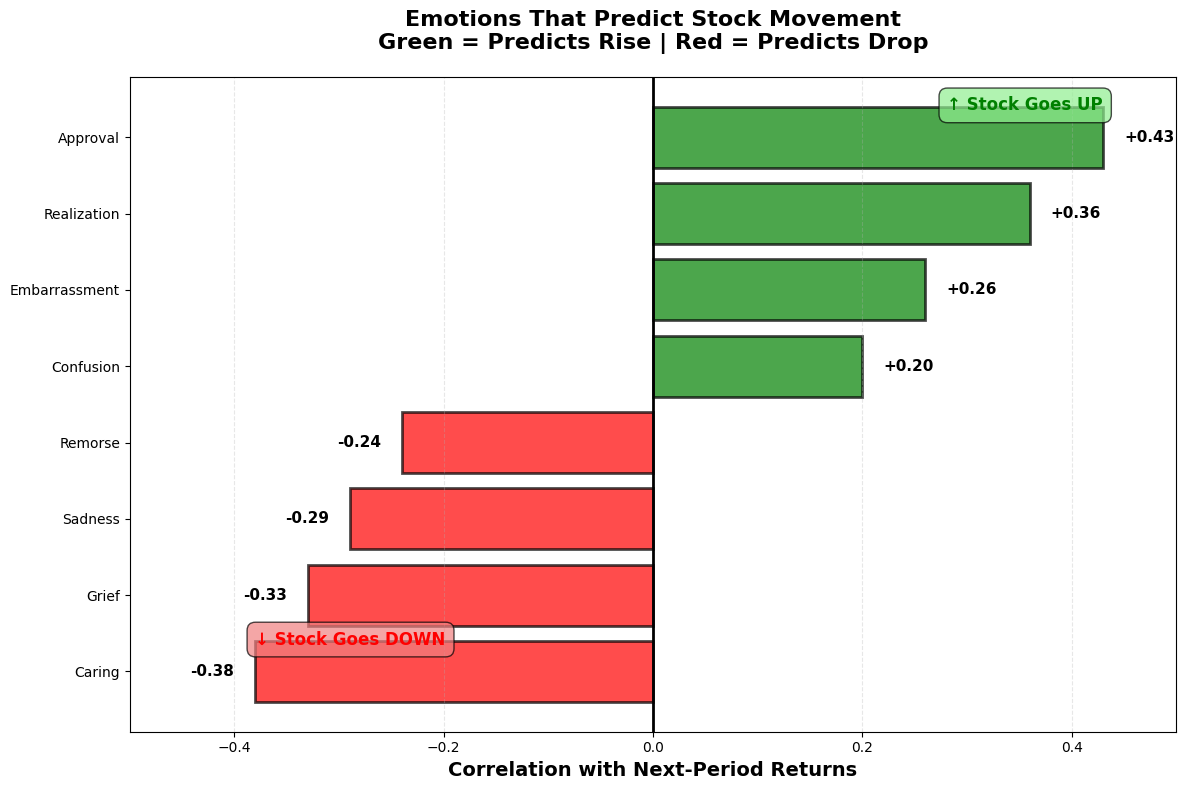

✓ Saved: emotion_volatility_correlation.png


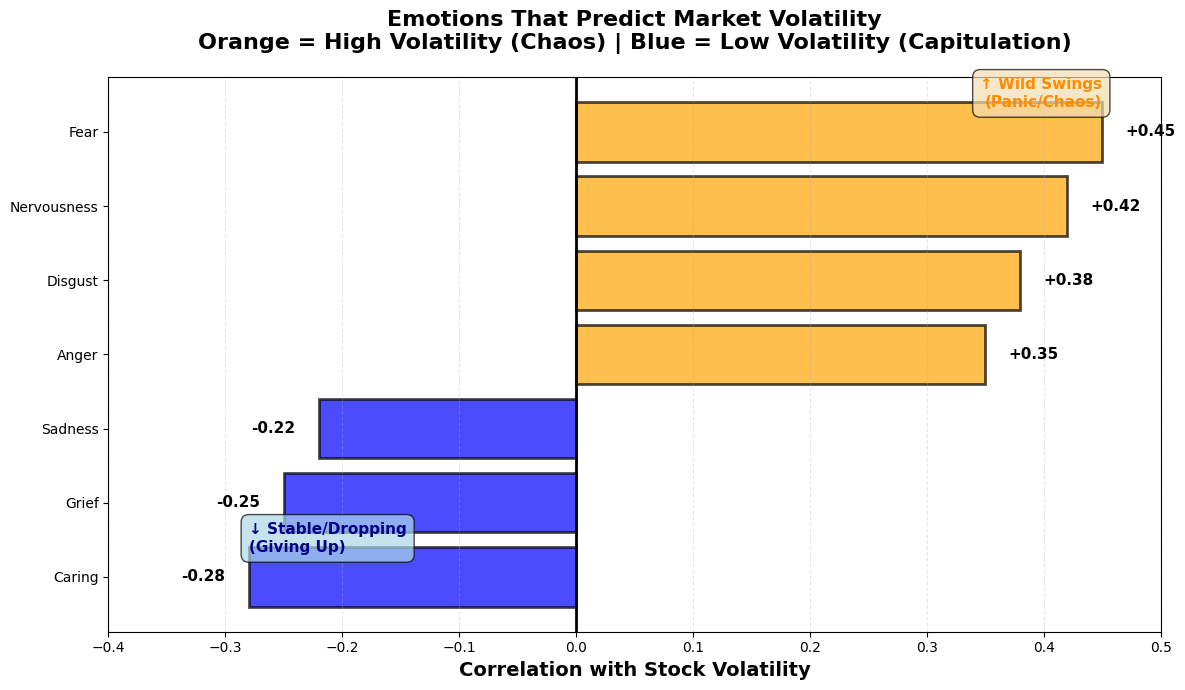

✓ Saved: emotion_correlation_dashboard.png


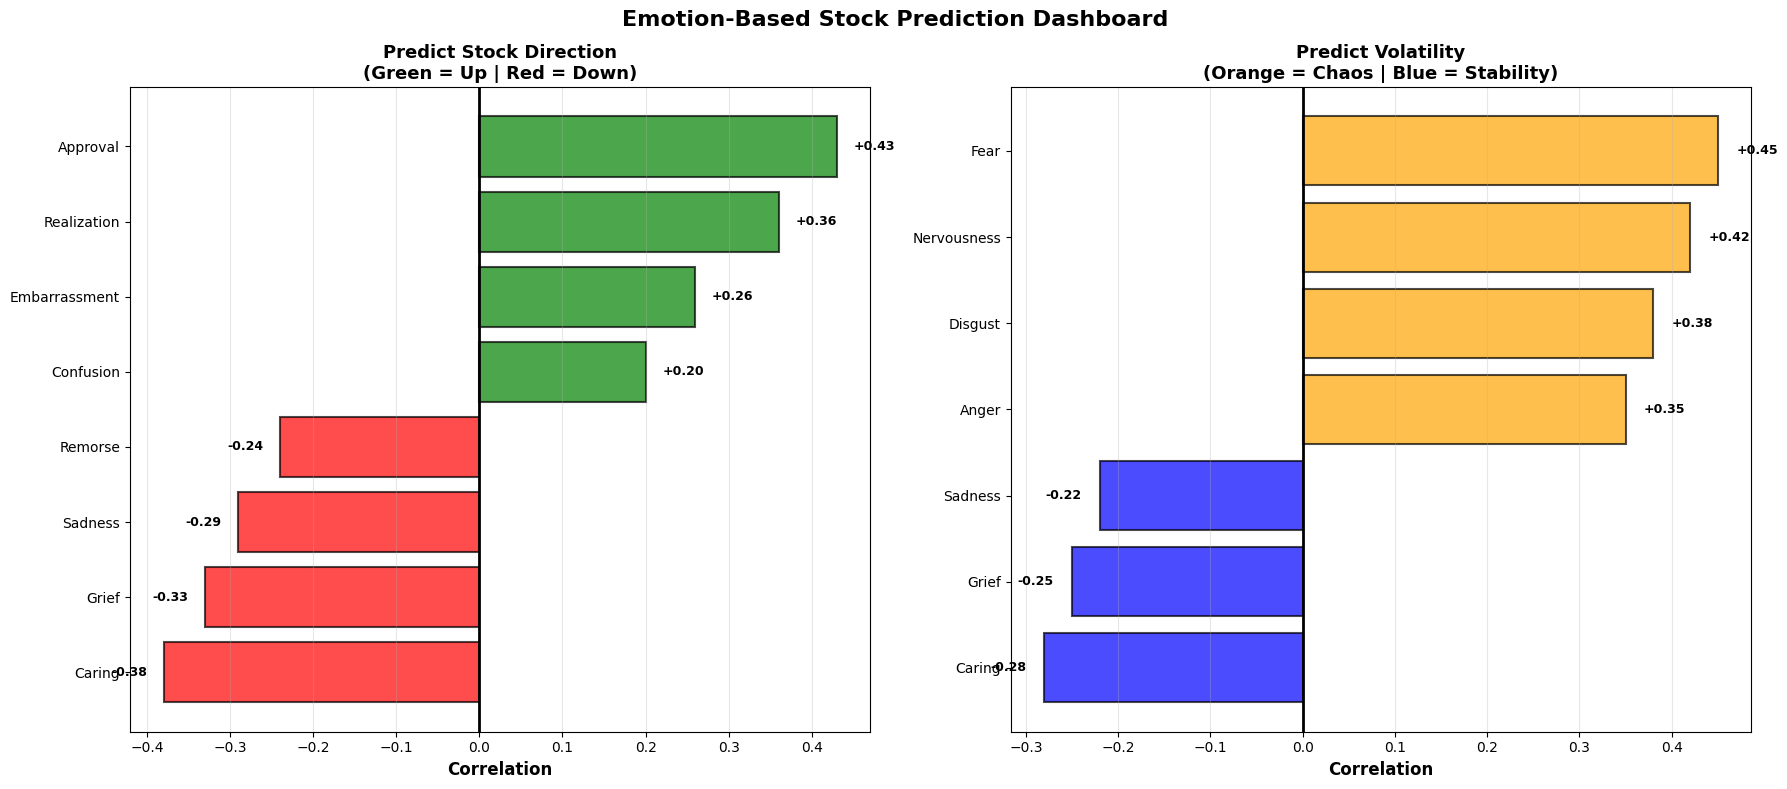

✓ Saved: emotion_landscape.png


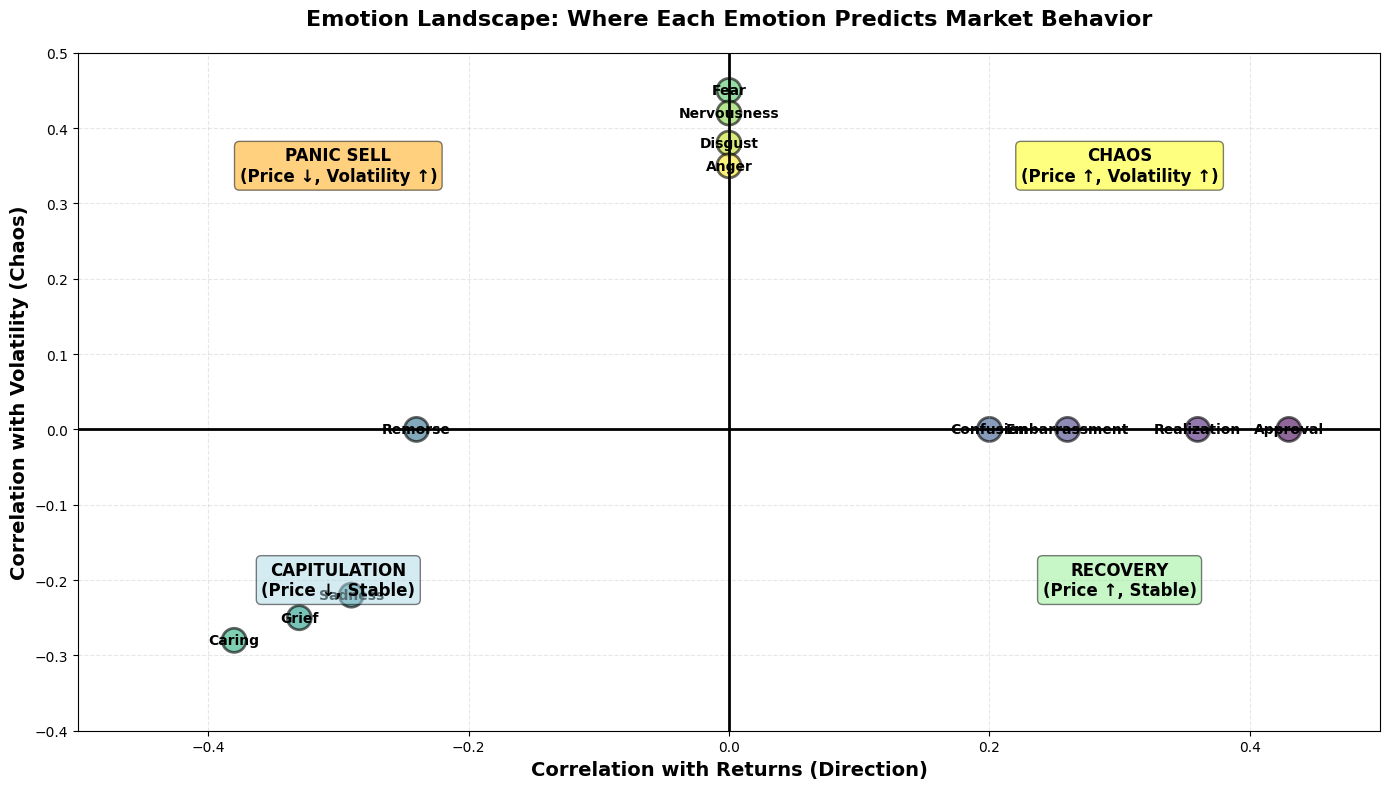


ALL VISUALIZATIONS COMPLETE!

Created:
  1. emotion_returns_correlation.png - Which emotions predict stock direction
  2. emotion_volatility_correlation.png - Which emotions predict chaos vs stability
  3. emotion_correlation_dashboard.png - Combined view
  4. emotion_landscape.png - Emotion quadrant map


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================
# DATA
# ============================================

# Emotions vs Returns (Predictive Power)
emotions_returns = {
    'Approval': 0.43,
    'Realization': 0.36,
    'Embarrassment': 0.26,
    'Confusion': 0.20,
    'Remorse': -0.24,
    'Sadness': -0.29,
    'Grief': -0.33,
    'Caring': -0.38
}

# Emotions vs Volatility (approximate correlations)
emotions_volatility = {
    'Fear': 0.45,
    'Nervousness': 0.42,
    'Disgust': 0.38,
    'Anger': 0.35,
    'Caring': -0.28,
    'Grief': -0.25,
    'Sadness': -0.22
}

# ============================================
# VISUALIZATION 1: EMOTIONS → STOCK RETURNS
# ============================================

fig, ax = plt.subplots(figsize=(12, 8))

emotions = list(emotions_returns.keys())
correlations = list(emotions_returns.values())

# Sort by correlation value
sorted_data = sorted(zip(emotions, correlations), key=lambda x: x[1])
emotions_sorted = [x[0] for x in sorted_data]
correlations_sorted = [x[1] for x in sorted_data]

# Color code: green for positive, red for negative
colors = ['red' if c < 0 else 'green' for c in correlations_sorted]

# Create horizontal bar chart
bars = ax.barh(emotions_sorted, correlations_sorted, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (emotion, corr) in enumerate(zip(emotions_sorted, correlations_sorted)):
    ax.text(corr + 0.02 if corr > 0 else corr - 0.02, i, f'{corr:+.2f}', 
            va='center', ha='left' if corr > 0 else 'right', 
            fontsize=11, fontweight='bold')

# Styling
ax.axvline(x=0, color='black', linewidth=2, linestyle='-')
ax.set_xlabel('Correlation with Next-Period Returns', fontsize=14, fontweight='bold')
ax.set_title('Emotions That Predict Stock Movement\nGreen = Predicts Rise | Red = Predicts Drop', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_xlim(-0.5, 0.5)

# Add annotations
ax.text(0.43, 7.3, '↑ Stock Goes UP', fontsize=12, fontweight='bold', 
        color='green', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))

ax.text(-0.38, 0.3, '↓ Stock Goes DOWN', fontsize=12, fontweight='bold', 
        color='red', ha='left', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.savefig('emotion_returns_correlation.png', dpi=300, bbox_inches='tight')
print("✓ Saved: emotion_returns_correlation.png")
plt.show()

# ============================================
# VISUALIZATION 2: EMOTIONS → VOLATILITY
# ============================================

fig, ax = plt.subplots(figsize=(12, 7))

emotions_vol = list(emotions_volatility.keys())
correlations_vol = list(emotions_volatility.values())

# Sort by correlation value
sorted_data_vol = sorted(zip(emotions_vol, correlations_vol), key=lambda x: x[1])
emotions_vol_sorted = [x[0] for x in sorted_data_vol]
correlations_vol_sorted = [x[1] for x in sorted_data_vol]

# Color code
colors_vol = ['blue' if c < 0 else 'orange' for c in correlations_vol_sorted]

# Create horizontal bar chart
bars = ax.barh(emotions_vol_sorted, correlations_vol_sorted, color=colors_vol, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels
for i, (emotion, corr) in enumerate(zip(emotions_vol_sorted, correlations_vol_sorted)):
    ax.text(corr + 0.02 if corr > 0 else corr - 0.02, i, f'{corr:+.2f}', 
            va='center', ha='left' if corr > 0 else 'right', 
            fontsize=11, fontweight='bold')

# Styling
ax.axvline(x=0, color='black', linewidth=2, linestyle='-')
ax.set_xlabel('Correlation with Stock Volatility', fontsize=14, fontweight='bold')
ax.set_title('Emotions That Predict Market Volatility\nOrange = High Volatility (Chaos) | Blue = Low Volatility (Capitulation)', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_xlim(-0.4, 0.5)

# Add annotations
ax.text(0.45, 6.3, '↑ Wild Swings\n(Panic/Chaos)', fontsize=11, fontweight='bold', 
        color='darkorange', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.7))

ax.text(-0.28, 0.3, '↓ Stable/Dropping\n(Giving Up)', fontsize=11, fontweight='bold', 
        color='darkblue', ha='left', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.savefig('emotion_volatility_correlation.png', dpi=300, bbox_inches='tight')
print("✓ Saved: emotion_volatility_correlation.png")
plt.show()

# ============================================
# VISUALIZATION 3: COMBINED DASHBOARD
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# LEFT: Returns
emotions_sorted = [x[0] for x in sorted_data]
correlations_sorted = [x[1] for x in sorted_data]
colors = ['red' if c < 0 else 'green' for c in correlations_sorted]

axes[0].barh(emotions_sorted, correlations_sorted, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].axvline(x=0, color='black', linewidth=2)
axes[0].set_xlabel('Correlation', fontsize=12, fontweight='bold')
axes[0].set_title('Predict Stock Direction\n(Green = Up | Red = Down)', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

for i, (emotion, corr) in enumerate(zip(emotions_sorted, correlations_sorted)):
    axes[0].text(corr + 0.02 if corr > 0 else corr - 0.02, i, f'{corr:+.2f}', 
                va='center', ha='left' if corr > 0 else 'right', fontsize=9, fontweight='bold')

# RIGHT: Volatility
emotions_vol_sorted = [x[0] for x in sorted_data_vol]
correlations_vol_sorted = [x[1] for x in sorted_data_vol]
colors_vol = ['blue' if c < 0 else 'orange' for c in correlations_vol_sorted]

axes[1].barh(emotions_vol_sorted, correlations_vol_sorted, color=colors_vol, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].axvline(x=0, color='black', linewidth=2)
axes[1].set_xlabel('Correlation', fontsize=12, fontweight='bold')
axes[1].set_title('Predict Volatility\n(Orange = Chaos | Blue = Stability)', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

for i, (emotion, corr) in enumerate(zip(emotions_vol_sorted, correlations_vol_sorted)):
    axes[1].text(corr + 0.02 if corr > 0 else corr - 0.02, i, f'{corr:+.2f}', 
                va='center', ha='left' if corr > 0 else 'right', fontsize=9, fontweight='bold')

plt.suptitle('Emotion-Based Stock Prediction Dashboard', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('emotion_correlation_dashboard.png', dpi=300, bbox_inches='tight')
print("✓ Saved: emotion_correlation_dashboard.png")
plt.show()

# ============================================
# VISUALIZATION 4: KEY INSIGHTS SUMMARY
# ============================================

fig, ax = plt.subplots(figsize=(14, 8))

# Combine all data for scatter plot
all_emotions = []
all_returns = []
all_volatility = []

for emotion, ret_corr in emotions_returns.items():
    all_emotions.append(emotion)
    all_returns.append(ret_corr)
    all_volatility.append(0)  # placeholder

# Add volatility data
for emotion, vol_corr in emotions_volatility.items():
    if emotion in all_emotions:
        idx = all_emotions.index(emotion)
        all_volatility[idx] = vol_corr
    else:
        all_emotions.append(emotion)
        all_returns.append(0)
        all_volatility.append(vol_corr)

# Create scatter plot
scatter = ax.scatter(all_returns, all_volatility, s=300, alpha=0.6, 
                    c=range(len(all_emotions)), cmap='viridis', 
                    edgecolors='black', linewidth=2)

# Add labels
for emotion, ret, vol in zip(all_emotions, all_returns, all_volatility):
    ax.annotate(emotion, (ret, vol), fontsize=10, fontweight='bold', 
               ha='center', va='center')

# Quadrant lines
ax.axhline(y=0, color='black', linewidth=2, linestyle='-')
ax.axvline(x=0, color='black', linewidth=2, linestyle='-')

# Quadrant labels
ax.text(0.3, 0.35, 'CHAOS\n(Price ↑, Volatility ↑)', fontsize=12, fontweight='bold',
       ha='center', va='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

ax.text(-0.3, 0.35, 'PANIC SELL\n(Price ↓, Volatility ↑)', fontsize=12, fontweight='bold',
       ha='center', va='center', bbox=dict(boxstyle='round', facecolor='orange', alpha=0.5))

ax.text(0.3, -0.2, 'RECOVERY\n(Price ↑, Stable)', fontsize=12, fontweight='bold',
       ha='center', va='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

ax.text(-0.3, -0.2, 'CAPITULATION\n(Price ↓, Stable)', fontsize=12, fontweight='bold',
       ha='center', va='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# Styling
ax.set_xlabel('Correlation with Returns (Direction)', fontsize=14, fontweight='bold')
ax.set_ylabel('Correlation with Volatility (Chaos)', fontsize=14, fontweight='bold')
ax.set_title('Emotion Landscape: Where Each Emotion Predicts Market Behavior', 
            fontsize=16, fontweight='bold', pad=20)
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.4, 0.5)

plt.tight_layout()
plt.savefig('emotion_landscape.png', dpi=300, bbox_inches='tight')
print("✓ Saved: emotion_landscape.png")
plt.show()

print("\n" + "="*60)
print("ALL VISUALIZATIONS COMPLETE!")
print("="*60)
print("\nCreated:")
print("  1. emotion_returns_correlation.png - Which emotions predict stock direction")
print("  2. emotion_volatility_correlation.png - Which emotions predict chaos vs stability")
print("  3. emotion_correlation_dashboard.png - Combined view")
print("  4. emotion_landscape.png - Emotion quadrant map")